# Summary of this notebook
This notebook explores some alternatives for evaluating sequence flows. We did not pursued with them because they are too compute heavy or too complex (Sections "Alternative similarity measure for control flow: Graph Edit Distance" and "Alternative similarity measure for control flow: Behavioural comparison").

In [4]:
# import the sample data

import json

# load ground truth from examples
filename_ground_truth = f"../data/examples/ground-truth.json"
with open(filename_ground_truth, "r") as infile:
    ground_truth = json.load(infile)

# load generated from examples
filename_generated = f"../data/examples/generated.json"
with open(filename_generated, "r") as infile:
    generated = json.load(infile)

print(ground_truth)
print(generated)

{'tasks': [{'id': 'sid-FFF7A601-D7E5-4061-8409-146F24B72F13', 'name': 'Invite to job interview', 'type': 'Task'}, {'id': 'sid-53C132C5-359D-4E79-8FBB-99B7C41973C7', 'name': 'Prepare employment agreement', 'type': 'Task'}, {'id': 'sid-CAF14C6A-837F-417D-B67A-2A7B6362B5DB', 'name': 'Send receipt confirmation', 'type': 'Task'}, {'id': 'sid-18206754-99AE-4C11-B9A7-BEB27E81FED5', 'name': 'Send employment contract', 'type': 'Task'}, {'id': 'sid-31C0CE32-8227-44E5-B7F0-0501D5D57FB4', 'name': 'Send rejection', 'type': 'Task'}, {'id': 'sid-F7A0EA5F-240D-433C-A911-C815B73F9A3F', 'name': 'Verify applicant', 'type': 'Task'}, {'id': 'sid-6CCC5A9A-2512-4C46-93EB-90B1CDD0FFEC', 'name': 'Carry out job interview', 'type': 'Task'}], 'events': [{'id': 'sid-25311BE5-F820-4CB8-B325-EA5EA5E655AD', 'name': 'Application received', 'type': 'StartMessageEvent'}, {'id': 'sid-1809C426-6409-43F2-AD67-66E163ACA06F', 'name': 'Signed employment  contract is present', 'type': 'EndNoneEvent', 'outgoing': []}, {'id': 's

# Alternative similarity measure for control flow: Graph Edit Distance
Graph edit distance can better measure the similairity because it looks at the whole graph and not ony triples. The problem is that it is too resource consuming (NP hard). For small graphs it works. For our examples it takes multiple hours and for bigger even days making it not suitable for our use case.

In [10]:
import sys, json

sys.path.append("../")
sys.path.append("../src/")
sys.path.append("../data/")

from src.multimodalgenai.bpmn_schema_helper import get_name_by_id
import networkx as nx


# creates graph from json schema
def create_graph(schema):
    G = nx.DiGraph()
    for task in schema.get("tasks", []):
        G.add_node(task["name"])
    for event in schema.get("events", []):
        G.add_node(event["name"])
    for gateway in schema.get("gateways", []):
        G.add_node(gateway["name"])

    for flow in schema.get("sequenceFlows", []):
        source = get_name_by_id(schema, flow["sourceRef"])
        target = get_name_by_id(schema, flow["targetRef"])
        G.add_edge(source, target)

    return G

In [47]:
# Lets create the graph from our example
G1 = create_graph(ground_truth)
G2 = create_graph(generated)

In [37]:
G1.remove_nodes_from(list(nx.isolates(G1)))
G1.remove_edges_from(nx.selfloop_edges(G1))

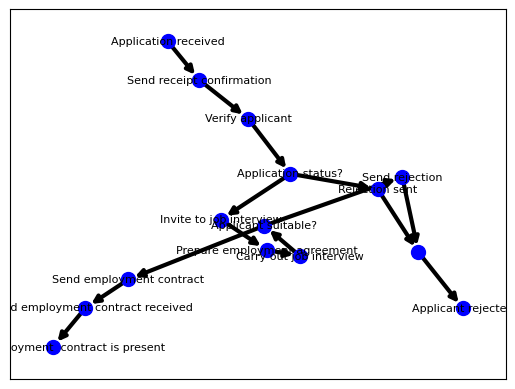

In [44]:
options = {
    "node_color": "blue",
    "node_size": 100,
    "width": 3,
    "arrowstyle": "-|>",
    "arrowsize": 11,
    "font_size": 8,
}
nx.draw_networkx(G1, arrows=True, **options)

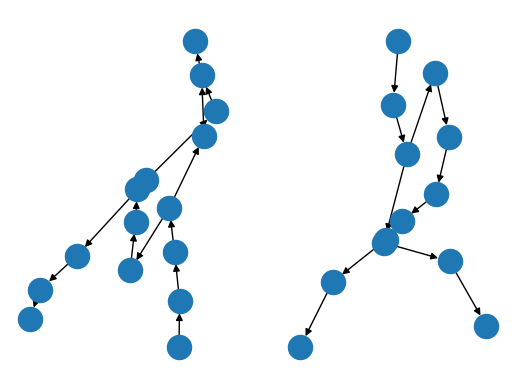

In [33]:
# Lets create the graph from our example
G1 = create_graph(ground_truth)
G2 = create_graph(generated)

G1.remove_nodes_from(list(nx.isolates(G1)))
G1.remove_edges_from(nx.selfloop_edges(G1))
G2.remove_nodes_from(list(nx.isolates(G2)))
G2.remove_edges_from(nx.selfloop_edges(G2))

import matplotlib.pyplot as plt

subax1 = plt.subplot(121)
nx.draw(G1)  # default spring_layout
subax2 = plt.subplot(122)
nx.draw(G2)

In [17]:
# # and calculate their graph edit distance. Takes multiple hours or up to a day to compute
# for v in nx.optimize_graph_edit_distance(G1, G2, timeout=120):
#     minv = v
# minv
nx.graph_edit_distance(G1, G2, timeout=360)

9.0

In [51]:
# Lets create a smaller one without directed edges, it takes less than a second, so it works
G1 = nx.Graph()
G1.add_nodes_from([1, 2, 3, 4])
G1.add_node("aka33", label="what do you do", type="task")
G1.add_node("aka34", label="what do you do", type="task")
G1.add_node("aka35", label="what do you do2", type="task")
G1.add_node("aka36", label="what do you do3", type="task")
G1.add_node("aka37", label="what do you do", type="gateway")
G1.add_node("aka38", label="what do you do", type="task")
G1.add_node("aka39", label="what do you do2", type="task")
G1.add_node("aka399", label="what do you do3", type="event")
G1.add_edges_from([(1, 2), (2, 3), (3, 4)])
G1.add_edge("aka37", "aka36")
G1.add_edge("aka35", "aka37")
G1.add_edge("aka35", "aka37")
G1.add_edge("aka33", "aka39")
G1.add_edge("aka39", "aka37")


# Graph 4: A highly complex graph
G4 = nx.Graph()

# Adding a large number of nodes
G4.add_nodes_from(range(1, 31))

# Adding a complex set of edges
import random

# Creating edges by randomly connecting nodes
for node in G4.nodes():
    for _ in range(random.randint(2, 5)):  # Each node will have 2 to 5 random connections
        G4.add_edge(node, random.randint(1, 30))

# Removing self-loops and duplicate edges
G4 = nx.Graph(G4)  #


for v in nx.optimize_graph_edit_distance(G1, G4):
    minv = v
minv

103.0

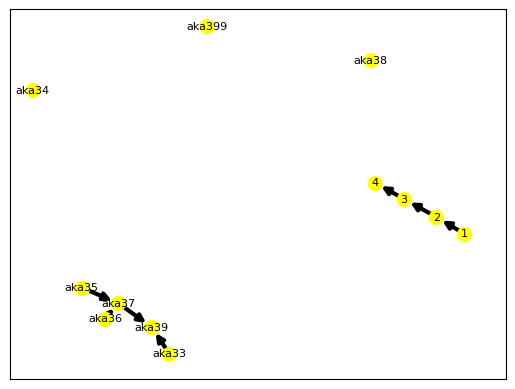

In [55]:
options = {
    "node_color": "yellow",
    "node_size": 100,
    "width": 3,
    "arrowstyle": "-|>",
    "arrowsize": 11,
    "font_size": 8,
}
nx.draw_networkx(G1, arrows=True, **options)

In [56]:
nx.graph_edit_distance(G1, G4)

103.0

In [57]:
# and this one which is more realistic
MyG1 = nx.DiGraph()
MyG1.add_node("Send receipt confirmation")
MyG1.add_node("Applicant verified")
MyG1.add_node("Invite to job interview")
MyG1.add_node("Prepare employment agreement")
MyG1.add_node("Carry out job interview")
MyG1.add_node("Send employment contract")
MyG1.add_node("Send rejection")
MyG1.add_node("Receipt of application")
MyG1.add_node("Receipt of signed employment contract")
MyG1.add_node("Signed employment contract is present")
MyG1.add_node("Rejection sent")
MyG1.add_node("Applicant rejected")
MyG1.add_node("Applicant suitable")

MyG1.add_edge("Receipt of application", "Send receipt confirmation")
MyG1.add_edge("Send receipt confirmation", "Applicant suitable")
MyG1.add_edge("Applicant suitable", "Applicant verified")
MyG1.add_edge("Applicant verified", "Invite to job interview")
MyG1.add_edge("Invite to job interview", "Prepare employment agreement")
MyG1.add_edge("Prepare employment agreement", "Carry out job interview")
MyG1.add_edge("Carry out job interview", "Send employment contract")
MyG1.add_edge("Send employment contract", "Receipt of signed employment contract")
MyG1.add_edge("Receipt of signed employment contract", "Signed employment contract is present")
MyG1.add_edge("Applicant suitable", "Send rejection")
MyG1.add_edge("Send rejection", "Rejection sent")
MyG1.add_edge("Rejection sent", "Applicant rejected")

MyG2 = nx.DiGraph()
MyG2.add_node("Invite to job interview")
MyG2.add_node("Prepare employment agreement")
MyG2.add_node("Send receipt confirmation")
MyG2.add_node("Send employment contract")
MyG2.add_node("Send rejection")
MyG2.add_node("Verify applicant")
MyG2.add_node("Carry out job interview")
MyG2.add_node("Application received")
MyG2.add_node("Signed employment contract is present")
MyG2.add_node("Signed employment contract received")
MyG2.add_node("Rejection sent")
MyG2.add_node("Applicant rejected")
MyG2.add_node("Applicant suitable?")
MyG2.add_node("Application status?")

MyG2.add_edge("Verify applicant", "Application status?")
MyG2.add_edge("Invite to job interview", "Prepare employment agreement")
MyG2.add_edge("Application received", "Send receipt confirmation")
MyG2.add_edge("Send receipt confirmation", "Verify applicant")
MyG2.add_edge("Prepare employment agreement", "Carry out job interview")
MyG2.add_edge("Carry out job interview", "Applicant suitable?")
MyG2.add_edge("Send employment contract", "Signed employment contract received")
MyG2.add_edge("Applicant suitable?", "Send employment contract")
MyG2.add_edge("Applicant suitable?", "Send rejection")

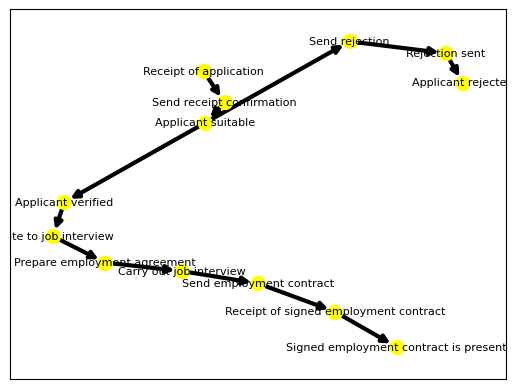

In [68]:
options = {
    "node_color": "yellow",
    "node_size": 100,
    "width": 3,
    "arrowstyle": "-|>",
    "arrowsize": 11,
    "font_size": 8,
}
nx.draw_networkx(MyG1, arrows=True, **options)

In [71]:
nx.graph_edit_distance(MyG1, MyG2, timeout=500)

6.0

In [ ]:
# and this one which is more realistic
MyG1 = nx.DiGraph()
MyG1.add_node("Send receipt confirmation")
MyG1.add_node("Applicant verified")
MyG1.add_node("Invite to job interview")
MyG1.add_node("Prepare employment agreement")
MyG1.add_node("Carry out job interview")
MyG1.add_node("Send employment contract")
MyG1.add_node("Send rejection")
MyG1.add_node("Receipt of application")
MyG1.add_node("Receipt of signed employment contract")
MyG1.add_node("Signed employment contract is present")
MyG1.add_node("Rejection sent")
MyG1.add_node("Applicant rejected")
MyG1.add_node("Applicant suitable")

MyG1.add_edge("Receipt of application", "Send receipt confirmation")
MyG1.add_edge("Send receipt confirmation", "Applicant suitable")
MyG1.add_edge("Applicant suitable", "Applicant verified")
MyG1.add_edge("Applicant verified", "Invite to job interview")
MyG1.add_edge("Invite to job interview", "Prepare employment agreement")
MyG1.add_edge("Prepare employment agreement", "Carry out job interview")
MyG1.add_edge("Carry out job interview", "Send employment contract")
MyG1.add_edge("Send employment contract", "Receipt of signed employment contract")
MyG1.add_edge("Receipt of signed employment contract", "Signed employment contract is present")
MyG1.add_edge("Applicant suitable", "Send rejection")
MyG1.add_edge("Send rejection", "Rejection sent")
MyG1.add_edge("Rejection sent", "Applicant rejected")

MyG2 = nx.DiGraph()
MyG2.add_node("Invite to job interview")
MyG2.add_node("Prepare employment agreement")
MyG2.add_node("Send receipt confirmation")
MyG2.add_node("Send employment contract")
MyG2.add_node("Send rejection")
MyG2.add_node("Verify applicant")
MyG2.add_node("Carry out job interview")
MyG2.add_node("Application received")
MyG2.add_node("Signed employment contract is present")
MyG2.add_node("Signed employment contract received")
MyG2.add_node("Rejection sent")
MyG2.add_node("Applicant rejected")
MyG2.add_node("Applicant suitable?")
MyG2.add_node("Application status?")

MyG2.add_edge("Verify applicant", "Application status?")
MyG2.add_edge("Invite to job interview", "Prepare employment agreement")
MyG2.add_edge("Application received", "Send receipt confirmation")
MyG2.add_edge("Send receipt confirmation", "Verify applicant")
MyG2.add_edge("Prepare employment agreement", "Carry out job interview")
MyG2.add_edge("Carry out job interview", "Applicant suitable?")
MyG2.add_edge("Send employment contract", "Signed employment contract received")
MyG2.add_edge("Applicant suitable?", "Send employment contract")
MyG2.add_edge("Applicant suitable?", "Send rejection")
# MyG2.add_edge("Application status?", "Invite to job interview")
# MyG2.add_edge("Application status?", "Rejection sent")
# MyG2.add_edge("Signed employment contract received", "Signed employment contract is present")


MyG1.remove_nodes_from(list(nx.isolates(MyG1)))
MyG2.remove_nodes_from(list(nx.isolates(MyG2)))

import matplotlib.pyplot as plt
subax1 = plt.subplot(121)
nx.draw(MyG1)   # default spring_layout
subax2 = plt.subplot(122)
nx.draw(MyG2)

# we experiment by commenting out lines of the graph
# computing time is rising expotentially for 10 seconds to 1 minute to 5 minutes to 20 mins 
# to an hour to multiple hours or even days (realistic multiple hours)
for v in nx.optimize_graph_edit_distance(MyG1, MyG2):
    minv = v
minv 

# Alternative similarity measure for control flow: Behavioural comparison
Another common way to compare BPMN models is by comparing their actual behaviour ability. There are three main ways:
1. Comparing event logs: Generating all possible event logs with the models and comparing them.
2. Token replay: Trying to replay an event log from one model with the other model
3. Causality footprint matrix: Calculating a casuality matrix (for example activity A comes before B, activity C is parallel to D etc.) for both models and then comparing the matrices.

For this to work we need to simulate the processes and need an BPMN engine. Signavio and pm4py would be able to do that but sadly dont support an easy import. Both need X and Y painting coordinates for the diagram import which we dont have. pm4py also supports petri net import but transforming the json model into that is not a trvial task. Therefore I dont pursue this solution further.

c:\Users\I566116\AppData\Local\anaconda3\envs\multimodalgenai\lib\site-packages\pm4py\util\dt_parsing\parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
parsing log, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 1009.26it/s]

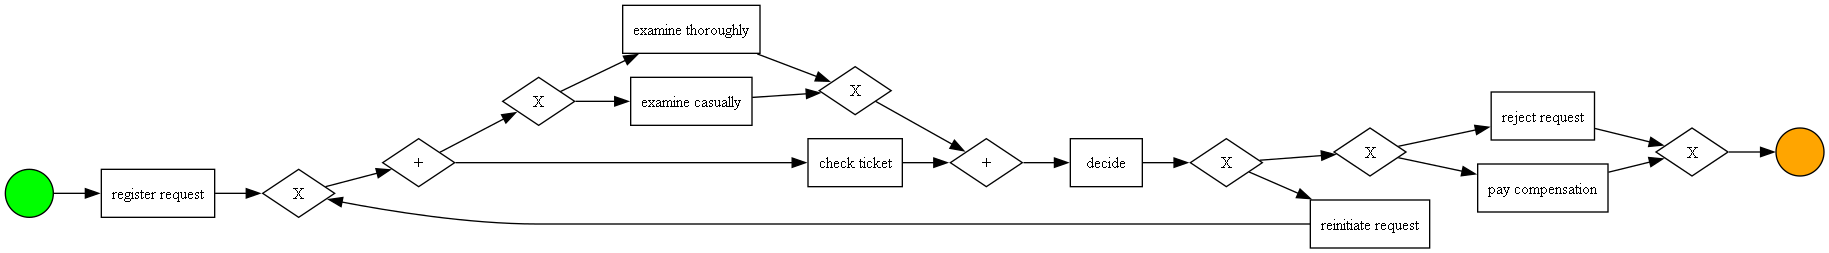

In [37]:
import pm4py
import pandas
import os

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

file_path = f"../data/examples/pm4py-example.xes"
log = pm4py.read_xes(file_path)
process_tree = pm4py.discover_process_tree_inductive(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model) # would need to transform to petri net for token replay and causalility footprint comparison

In [39]:
# export it to look into the schema
file_export = f"../data/examples/pm4py-export.bpmn"
pm4py.write_bpmn(bpmn_model, file_export)

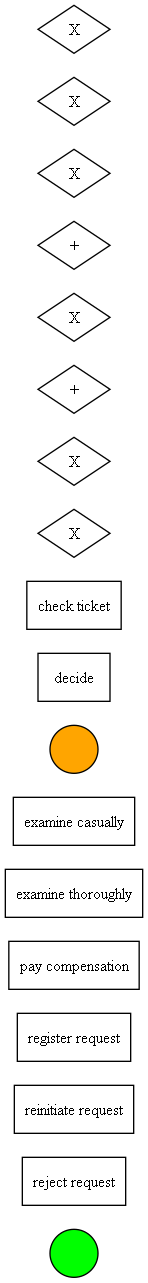

In [40]:
# import it again (I removed the x and y painting coordinates from the export). 
# now it lost the control flow. We sady need x and y coordinates to work with the bpmn import

from pm4py.objects.bpmn.layout import layouter

file_import = f"../data/examples/pm4py-import.bpmn"
bpmn_model_import = pm4py.read_bpmn(file_import)
bpmn_graph = layouter.apply(bpmn_model_import)
pm4py.view_bpmn(bpmn_graph)